# A Cat Wordcloud Using Reddit Comments

In [1]:
#imports
import requests
import pandas as pd
from datetime import datetime
import spacy
import praw

### Authentication and Data Retrieval

In order to use the Twitter API, you need to [register and request](https://docs.google.com/forms/d/e/1FAIpQLSezNdDNK1-P8mspSbmtC2r86Ee9ZRbC66u929cG2GX0T9UMyw/viewform) the API key from Reddit. The process is very simple and should not take more than a couple of days to get approved.

If you do not already have a Reddit account, you will need to create one.

The below code authenticates the user and retrieves comment data from the desired subreddit.

In [2]:
# authenticate

CLIENT_ID = 'INSET_CLIENT_ID' #Add your client id here
SECRET_KEY = 'INSERT_SECRET_KEY' #add your secret key here

reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=SECRET_KEY,
                     user_agent='Bot/0.0.1', #this can be anything
                    username = 'INSERT_LOGIN', # add your username here
                     password = 'INSERT_PASSWORD') # add your password here

# enter start and end date of the posts you want to get comments from
start_date = datetime(2022,6,8)
end_date = datetime(2022,6,9)

# select subreddit you want to get comments from
subreddit = reddit.subreddit('cats')

# create an empty dict that will contain all words and counts
conversedict = {}

# load Spacy tagger. This will help us later with selecting the words we want to use
nlp = spacy.load('en_core_web_sm')

# number of subreddits to analyze
hot_reddit = subreddit.hot(limit=100)

# record time of posts
time_list = []

# iterate through each subreddit
for submission in hot_reddit:
    
    # record the time the post was made at
    post_time = datetime.fromtimestamp(submission.created)
        
    # only process posts from today
    if post_time >= start_date and post_time < end_date and submission.stickied == False:
        
        time_list.append([submission.title,post_time])
    
        submission.comments.replace_more(limit=0) #grab commens that are hidden in a comment tree

        for comment in submission.comments.list(): #make a list of all comments
                        
            doc = nlp(comment.body) #tag words in a comment with parts of speech
            for ent in doc: #iterate through each word

                # check if the value exists in the conversedict. If no, add it. If yes, increment count by 1
                # add _SPLITTER_ value between the word and the tag. we will later split this value
                conversedict[str(ent)+"_SPLITTER_"+str(ent.pos_)] = conversedict.get(str(ent)+"_SPLITTER_"+str(ent.pos_), 0) + 1


Version 7.0.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


### Cleaning and Wrangling of the Dataset

The below code cleans and transforms the data into our desired format.

In [3]:
# convert dictionary to pd df and turn index into a column

df = pd.DataFrame.from_dict(conversedict, orient='index')
df.reset_index(level=0, inplace=True)

# rename columns
df.columns = ['Word Tag','count']

# split the word tag column into two columns and drop the original column

df[['Word','Tag']] = df['Word Tag'].str.split('_SPLITTER_',n=1,expand=True)
df.drop(['Word Tag'],axis=1,inplace=True)

# remove special charachters
df = df[~df.Word.str.contains(r'[^0-9a-zA-Z-$+]')]

# keep only nouns, proper nouns, verbs, and adjectives
contains_noun = df['Tag'].str.contains('NOUN')
contains_pnoun = df['Tag'].str.contains('PROPN')
contains_adj = df['Tag'].str.contains('ADJ')
contains_verb = df['Tag'].str.contains('VERB')

# adding copy makes sure that this is not a subset of the df, but a new df.
df_new = df[contains_noun | contains_pnoun | contains_adj | contains_verb].copy()

df_new['Word'] = df_new['Word'].str.upper()

# remove grammar words
excluded_words = ['BE','BEING','BEEN','HAVE','ARE','WAS','WERE','IS','DO','DID','DONE','HAD','HAS']
df_new = df_new[~df_new['Word'].isin(excluded_words)]

# remove one letter words
df_new = df_new[df_new['Word'].str.len()>1]

df_new = df_new.groupby(['Word'], as_index=False).agg({'count': 'sum'})
df_new.sort_values('count', ascending=False,inplace=True)
df_new.reset_index(drop=True,inplace=True)

df_new.head(10)

,Word,count
0,CAT,199
1,KITTENS,138
2,CATS,134
3,TAKE,67
4,LOVE,61
5,GOOD,59
6,KITTEN,58
7,GET,54
8,VIDEO,51
9,CUTE,50


### Dataset overview

Let's check how many posts and words we have extracted.

In [4]:
print('number of posts extracted: ',len(time_list))

number of posts extracted:  93


In [5]:
# shows count of only nouns, proper nouns, adjectives, and verbs
print('total word count:',df_new['count'].sum())

total word count: 9642


In [6]:
# shows count of all words extracted from the subreddit
print('total word count:',df['count'].sum())

total word count: 23155


In [7]:
print('# of unique words: ',df_new['Word'].count())

# of unique words:  2934


### Visualizing the cat comments

Now that we have a dataframe consisting of words and their counts we're ready to make our word cloud.

In [8]:
# additional imports for the viz
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

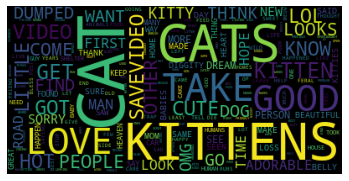

In [9]:
# take only top 500 words from our dataset
data_viz = df_new[['Word','count']].head(500)

# wordcloud library requires the data to be passed in tuples
viz_tuples = [tuple(x) for x in data_viz.values]

# visualizing the 
wordcloud = WordCloud().generate_from_frequencies(dict(viz_tuples))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We have generated our word cloud but it is hard to read and the colors are not appealing. Let's change that.

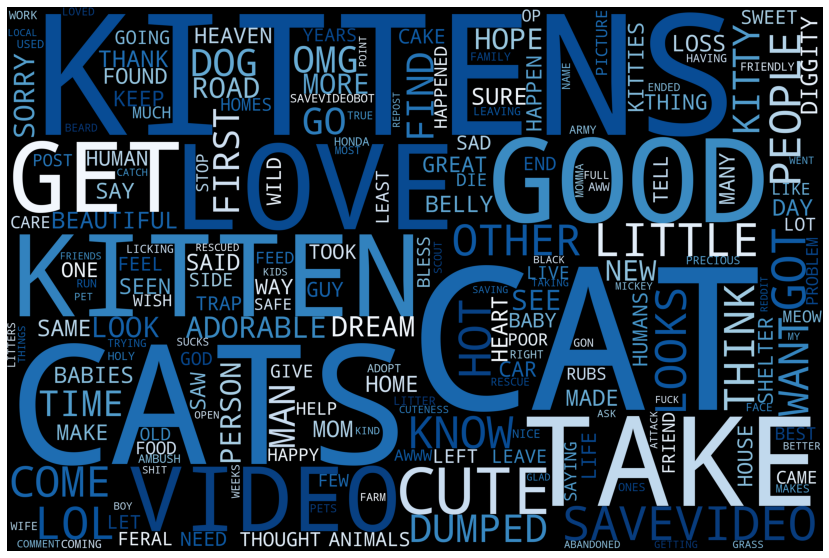

In [10]:
# Define a function to plot word cloud. Let's adjust the colors
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Generate word cloud using new
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Blues',
                      collocations=False).generate_from_frequencies(dict(viz_tuples))
# Plot
plot_cloud(wordcloud)

This looks much better. But we can further adjust it by making it in a shape of a cat. The image I found appears to have a white background but if we inspect it further, we see that the background is in a very light gray color. The wordcloud background needs to be completely white.

In [11]:
cat_mask = np.array(Image.open('cat.png'))
cat_mask[:1]

array([[[238, 238, 238, 255],
        [238, 238, 238, 255],
        [238, 238, 238, 255],
        ...,
        [238, 238, 238, 255],
        [238, 238, 238, 255],
        [238, 238, 238, 255]]], dtype=uint8)

It looks like each pixel of the background has 238 and 255 values in it. Let's change all instances of 238 to 255 to achieve a perfectly white background.

In [12]:
cat_mask[cat_mask == 238] = 255
cat_mask[:1]

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]]], dtype=uint8)

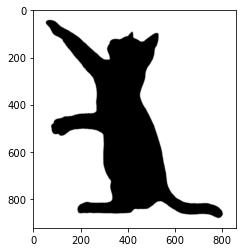

In [13]:
plt.imshow(cat_mask)
plt.show()

Our image is now ready to be used in our wordcloud. Let's go ahead and plot a few graphs with different color combinations. You can find different color codes for matplotlib [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

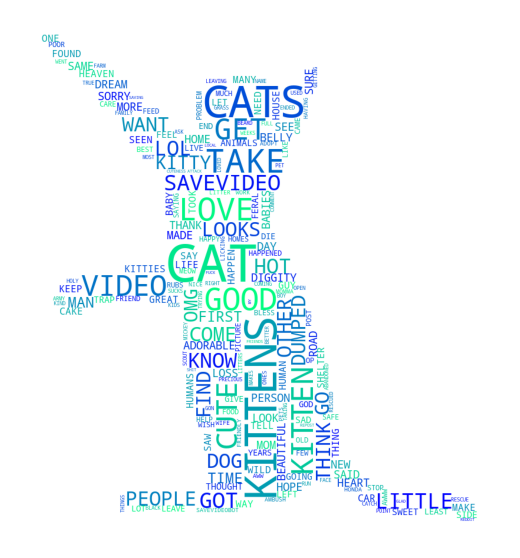

In [14]:
# Generate word cloud
wordcloud = WordCloud(width = 1000, height = 1200, random_state=1,
                      mask=cat_mask, background_color='white', colormap='winter_r',
                      collocations=False).generate_from_frequencies(dict(viz_tuples))
# Plot
plot_cloud(wordcloud)

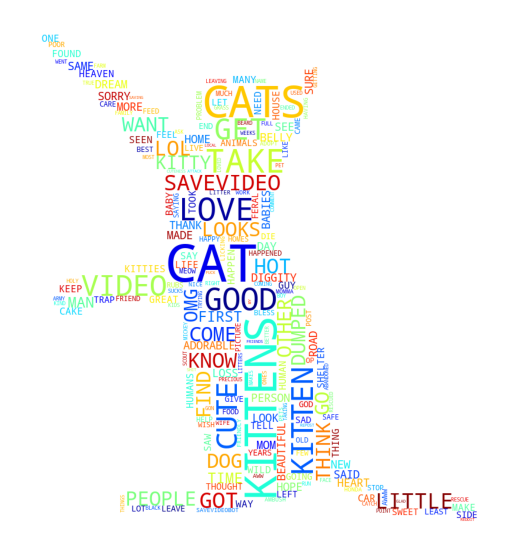

In [15]:
# Generate word cloud
wordcloud = WordCloud(width = 1000, height = 1200, random_state=1,
                      mask=cat_mask, background_color='white', colormap='jet',
                      collocations=False).generate_from_frequencies(dict(viz_tuples))
# Plot
plot_cloud(wordcloud)

I like the below version the most. We can go ahead and save it, make a post on reddit, and share what we have made with the community.

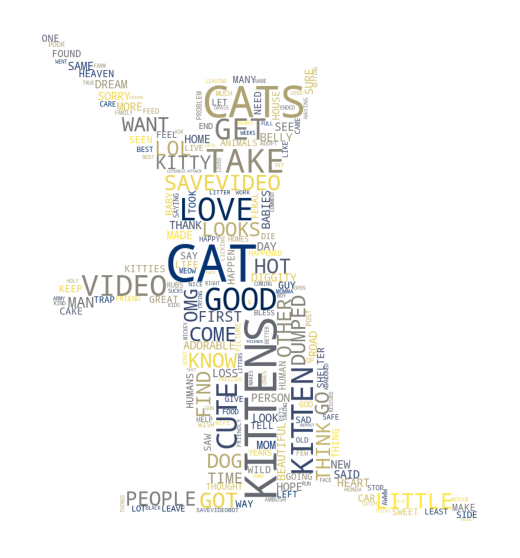

In [16]:
# Generate word cloud
wordcloud = WordCloud(width = 1000, height = 1200, random_state=1,
                      mask=cat_mask, background_color='white', colormap='cividis',
                      collocations=False).generate_from_frequencies(dict(viz_tuples))
# Plot
plot_cloud(wordcloud)

In [17]:
wordcloud.to_file('cat_cloud.png')